In [ ]:
# 1. Imports & Setup
import os
import json
import torch
import torchaudio
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import timm
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

In [51]:
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=320,
    n_mels=128
)
db_transform = AmplitudeToDB(top_db=80)

label_to_id = {"TVMA": 0, "TVFOURTEEN": 1, "TVYSEVEN": 2, "Non-Profane": 3}
id_to_label = {v: k for k, v in label_to_id.items()}



In [ ]:
# 2. Dataset Class with Automatic Non-Profane Labeling
import os, json
from torch.utils.data import Dataset
from collections import Counter

class ProfanityDataset(Dataset):
    def __init__(self, json_files, audio_dir, transform):
        self.samples = []
        self.transform = transform

        total_profane, total_nonprofane = 0, 0

        for js in json_files:
            with open(js) as f:
                data = json.load(f)
            for entry in data:
                path = os.path.join(audio_dir, os.path.basename(entry["audio"]))
                segments = sorted(entry["label"], key=lambda x: float(x["start"]))
                last_end = 0.0
                for seg in segments:
                    start = float(seg["start"])
                    end = float(seg["end"])
                    label = seg["labels"][0]
                    if start > last_end:
                        self.samples.append((path, last_end, start, label_to_id["Non-Profane"]))
                        total_nonprofane += 1
                    self.samples.append((path, start, end, label_to_id[label]))
                    total_profane += 1
                    last_end = end

        print(f"\n Processed {len(json_files)} annotation files")
        print(f" Loaded {len(set([s[0] for s in self.samples]))} unique audio clips")
        print(f" Total Segments: {len(self.samples)}")
        print(f" Profane Segments: {total_profane}")
        print(f" Non-Profane Segments: {total_nonprofane}")
        print(" Class-wise Distribution:")
        for class_id, count in sorted(Counter([s[-1] for s in self.samples]).items()):
            print(f"  Class {class_id} ({id_to_label[class_id]}): {count} segments")


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, start, end, label = self.samples[idx]
        waveform, sr = torchaudio.load(path)
        waveform = torchaudio.functional.resample(waveform, sr, 16000).mean(dim=0, keepdim=True)

        start_i = int(start * 16000)
        end_i = int(end * 16000)
        waveform = waveform[:, start_i:end_i]

        if waveform.shape[1] < 16000:
            pad = torch.zeros(1, 16000 - waveform.shape[1])
            waveform = torch.cat((waveform, pad), dim=1)
        else:
            waveform = waveform[:, :16000]

        mel = self.transform(waveform)
        mel_db = db_transform(mel).squeeze(0).transpose(0, 1)
        mel_db = torch.nn.functional.interpolate(mel_db.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear').squeeze()

        return mel_db.unsqueeze(0), torch.tensor(label)

In [ ]:
import os, json
from torch.utils.data import Dataset
from collections import Counter

class ProfanityDataset(Dataset):
    def __init__(self, json_files, audio_dir, transform):
        self.samples = []
        self.transform = transform

        file_map = {
            f.split("_")[0]: os.path.join(audio_dir, f)
            for f in os.listdir(audio_dir)
            if f.endswith(".mp3") or f.endswith(".wav")
        }

        total_profane, total_nonprofane = 0, 0
        matched_files = set()

        for js in json_files:
            with open(js) as f:
                data = json.load(f)

            for entry in data:
                target_suffix = entry["audio"].split("/")[-1].split("-")[-1] 
                matched_file = None
                for f in os.listdir(audio_dir):
                    if f.endswith(target_suffix):
                        matched_file = os.path.join(audio_dir, f)
                        break

                if not matched_file:
                    print(f"⚠️ Audio not found for: {entry['audio']}")
                    continue

                matched_files.add(matched_file)
                segments = sorted(entry["label"], key=lambda x: float(x["start"]))
                last_end = 0.0

                for seg in segments:
                    start = float(seg["start"])
                    end = float(seg["end"])
                    label = seg["labels"][0]

                    if start > last_end:
                        self.samples.append((matched_file, last_end, start, label_to_id["Non-Profane"]))
                        total_nonprofane += 1

                    self.samples.append((matched_file, start, end, label_to_id[label]))
                    total_profane += 1
                    last_end = end

        print(f"\n Loaded {len(self.samples)} segments")
        print(f" Profane: {total_profane}, Non-Profane: {total_nonprofane}")
        print(f" Matched Audio Files: {len(matched_files)}")
        print(" Class Distribution:", Counter([s[-1] for s in self.samples]))
        print(f"\n Processed {len(json_files)} annotation files")
        print(f" Loaded {len(set([s[0] for s in self.samples]))} unique audio clips")
        print(f" Total Segments: {len(self.samples)}")
        print(f" Profane Segments: {total_profane}")
        print(f" Non-Profane Segments: {total_nonprofane}")
        print(" Class-wise Distribution:")
        for class_id, count in sorted(Counter([s[-1] for s in self.samples]).items()):
            print(f"  Class {class_id} ({id_to_label[class_id]}): {count} segments")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, start, end, label = self.samples[idx]
        waveform, sr = torchaudio.load(path)
        waveform = torchaudio.functional.resample(waveform, sr, 16000).mean(dim=0, keepdim=True)

        start_i = int(start * 16000)
        end_i = int(end * 16000)
        waveform = waveform[:, start_i:end_i]

        if waveform.shape[1] < 16000:
            pad = torch.zeros(1, 16000 - waveform.shape[1])
            waveform = torch.cat((waveform, pad), dim=1)
        else:
            waveform = waveform[:, :16000]

        mel = self.transform(waveform)
        mel_db = db_transform(mel).squeeze(0).transpose(0, 1)
        mel_db = torch.nn.functional.interpolate(mel_db.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear').squeeze()

        return mel_db.unsqueeze(0), torch.tensor(label)


In [ ]:
# 3. Prepare DataLoader with Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader

# Setup
profane_jsons = [    "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/label/chamak.json",
                     "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/label/ibtihaj.json",
                     "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/label/shahrior.json"]
audio_dir = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/Dataset/profane"
full_dataset = ProfanityDataset(profane_jsons, audio_dir, mel_transform)

all_labels = [s[-1] for s in full_dataset.samples]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(torch.zeros(len(all_labels)), all_labels))

train_ds = Subset(full_dataset, train_idx)
val_ds = Subset(full_dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


✅ Loaded 3675 segments
👉 Profane: 1848, Non-Profane: 1827
📁 Matched Audio Files: 1089
📊 Class Distribution: Counter({3: 1827, 1: 784, 0: 634, 2: 430})

📁 Processed 3 annotation files
📦 Loaded 1089 unique audio clips
✅ Total Segments: 3675
🔴 Profane Segments: 1848
🟢 Non-Profane Segments: 1827
📊 Class-wise Distribution:
  Class 0 (TVMA): 634 segments
  Class 1 (TVFOURTEEN): 784 segments
  Class 2 (TVYSEVEN): 430 segments
  Class 3 (Non-Profane): 1827 segments


In [ ]:
#  4. AST Model Definition
import timm
import torch.nn as nn

model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
model.head = nn.Linear(model.head.in_features, len(label_to_id))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

In [ ]:
# 5. Training Loop with AUC and Class-Wise Stats
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
best_acc = 0

for epoch in range(20):
    model.train()
    total_loss = 0
    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            output = model(mel)
            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())
            all_probs.extend(probs)

    acc = accuracy_score(all_labels, all_preds) * 100
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=list(id_to_label.keys())), all_probs, multi_class='ovr') * 100
        auc_str = f"{auc:.2f}%"
    except:
        auc_str = "N/A"

    print(f"Epoch {epoch+1:02d}:  Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}% | AUC: {auc_str}")
    print(classification_report(all_labels, all_preds, target_names=list(id_to_label.values()), zero_division=0))

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_v6_profanity.pth")

    scheduler.step()

Epoch 01: ✅ Loss: 1.2867 | Acc: 55.37% | AUC: 73.43%
              precision    recall  f1-score   support

        TVMA       0.34      0.28      0.31       127
  TVFOURTEEN       0.58      0.29      0.39       157
    TVYSEVEN       0.00      0.00      0.00        86
 Non-Profane       0.60      0.89      0.72       365

    accuracy                           0.55       735
   macro avg       0.38      0.37      0.35       735
weighted avg       0.48      0.55      0.49       735

Epoch 02: ✅ Loss: 0.9630 | Acc: 67.35% | AUC: 86.20%
              precision    recall  f1-score   support

        TVMA       0.86      0.05      0.09       127
  TVFOURTEEN       0.45      0.89      0.60       157
    TVYSEVEN       0.60      0.03      0.07        86
 Non-Profane       0.83      0.95      0.89       365

    accuracy                           0.67       735
   macro avg       0.69      0.48      0.41       735
weighted avg       0.73      0.67      0.59       735

Epoch 03: ✅ Loss: 0.7858

In [ ]:
torch.save(model.state_dict(), "best_v6_profanity.pth")

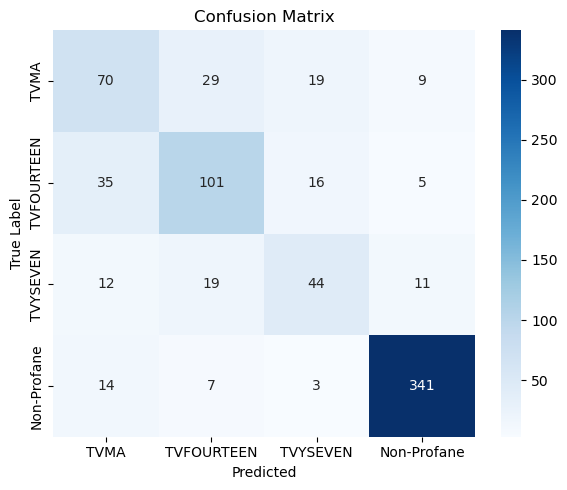

In [ ]:
#6. Confusion Matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[id_to_label[i] for i in range(4)], yticklabels=[id_to_label[i] for i in range(4)])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
#  0. Preprocessing Setup
import torchaudio
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from IPython.display import Audio

# ID-to-label mapping
id_to_label = {0: "TVMA", 1: "TVFOURTEEN", 2: "TVYSEVEN", 3: "Non-Profane"}

#  Define audio transforms
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=320,
    n_mels=128
)
db_transform = AmplitudeToDB(top_db=80)


In [ ]:
#  1. Load AST model
def load_model(model_path, device):
    import timm
    model = timm.create_model('vit_base_patch16_224', pretrained=False)
    model.patch_embed.proj = torch.nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    model.head = torch.nn.Linear(model.head.in_features, len(id_to_label))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


In [61]:
from scipy.ndimage import median_filter

def predict_clip(path, model, mel_transform, db_transform, device,
                 window_sec=0.5, stride_sec=0.25, threshold=0.4):

    waveform, sr = torchaudio.load(path)
    waveform = torchaudio.functional.resample(waveform, sr, 16000).mean(0, keepdim=True)
    sr = 16000

    win_len = int(window_sec * sr)
    stride_len = int(stride_sec * sr)
    total_len = waveform.shape[1]

    predicted_segments = []
    class_probs = []
    time_steps = []

    for start in range(0, total_len - win_len + 1, stride_len):
        end = start + win_len
        segment = waveform[:, start:end]

        mel = mel_transform(segment)
        mel_db = db_transform(mel).squeeze(0).transpose(0, 1)
        mel_resized = F.interpolate(mel_db.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear').squeeze()
        input_tensor = mel_resized.unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1).squeeze(0).cpu().numpy()
            class_probs.append(probs)
            time_steps.append(start / sr)

    class_probs = np.array(class_probs)
    smoothed_probs = median_filter(class_probs, size=(3, 1))  # Smooth over time

    for i, probs in enumerate(smoothed_probs):
        pred_idx = np.argmax(probs)
        confidence = probs[pred_idx]
        pred_class = id_to_label[pred_idx]

        if pred_class != "Non-Profane" and confidence >= threshold:
            start_time = time_steps[i]
            end_time = start_time + window_sec
            predicted_segments.append((start_time, end_time, f"{pred_class} ({confidence:.2f})"))

            print(f"[{start_time:.2f}s - {end_time:.2f}s] -> {pred_class} ({confidence:.2f})")

    return waveform, predicted_segments, time_steps, smoothed_probs


In [ ]:
#  3. Plot waveform with profane segments
import numpy as np
import matplotlib.pyplot as plt

def plot_segments(waveform, segments, sr=16000):
    plt.figure(figsize=(14, 4))
    waveform_np = waveform.squeeze().numpy()
    time = np.arange(len(waveform_np)) / sr

    plt.plot(time, waveform_np, label="Waveform", linewidth=1)

    for start, end, label in segments:
        if start < end:
            plt.axvspan(start, end, color='red', alpha=0.3)
            mid = (start + end) / 2
            plt.text(mid, 0.6 * waveform_np.max(), label, ha='center', color='black', fontsize=9)

    plt.title("🔊 Waveform with Detected Profane Segments")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [63]:
def plot_confidences(time_steps, smoothed_probs, class_names):
    plt.figure(figsize=(12, 4))
    for i, name in enumerate(class_names):
        plt.plot(time_steps, smoothed_probs[:, i], label=name)
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.title("Smoothed Class Confidence Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
#  4. Beep and save
def beep_and_save(path, profane_segments, output_path="beeped_output.wav"):
    waveform, sr = torchaudio.load(path)
    waveform = torchaudio.functional.resample(waveform, sr, 16000)
    waveform = waveform.mean(0, keepdim=True) if waveform.dim() > 1 else waveform.unsqueeze(0)
    sr = 16000

    beep = torch.sin(2 * torch.pi * 1000 * torch.linspace(0, 0.25, int(sr * 0.25))).unsqueeze(0)

    for s, e, _ in profane_segments:
        s_i = int(s * sr)
        e_i = int(e * sr)

        # Skip invalid segments
        if e_i <= s_i or (e_i - s_i) < 1:
            continue

        try:
            beep_resized = F.interpolate(beep.unsqueeze(0), size=e_i - s_i, mode="linear").squeeze(0)
            waveform[:, s_i:e_i] = beep_resized[:, :e_i - s_i]
        except Exception as err:
            print(f"⚠️ Skipped invalid beep segment: {s:.3f}-{e:.3f} sec | Reason: {err}")

    torchaudio.save(output_path, waveform, 16000)
    print(f" Beeped audio saved to: {output_path}")
    return Audio(output_path)



/var/folders/c0/fzgnj9q11_78qpvqll__gxvw0000gn/T/ipykernel_7763/3126857986.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

[1.50s - 2.00s] -> TVFOURTEEN (1.00)


/var/folders/c0/fzgnj9q11_78qpvqll__gxvw0000gn/T/ipykernel_7763/2086801168.py:22: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


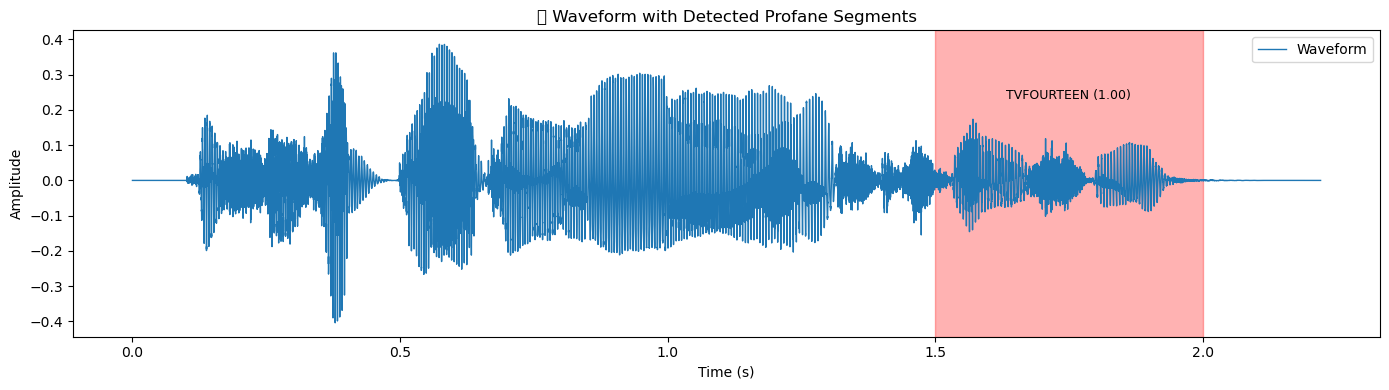

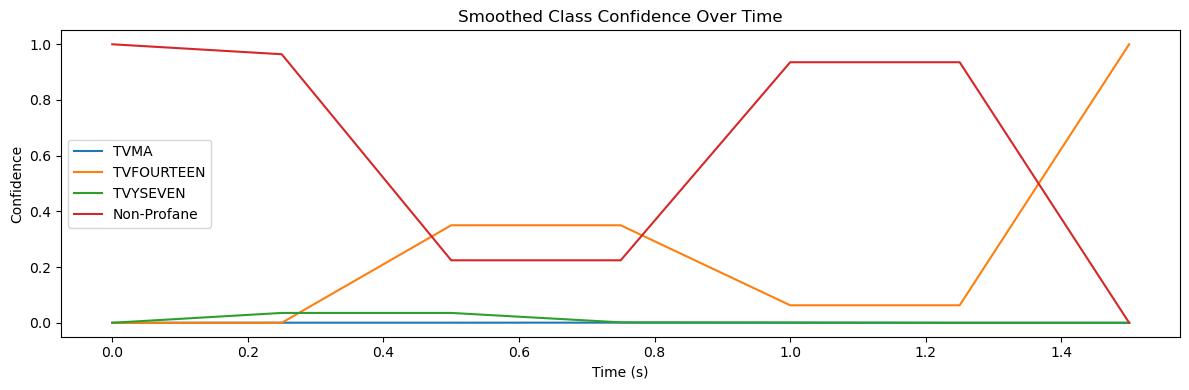

✅ Beeped audio saved to: beeped_output.wav


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model("best_v6_profanity.pth", device)

waveform, segments, time_steps, smoothed_probs = predict_clip(
    path="/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/profane/Tanvir/2371_profane.mp3",
    model=model,
    mel_transform=mel_transform,
    db_transform=db_transform,
    device=device,
    window_sec=0.5,
    stride_sec=0.25,
    threshold=0.9
)

class_names = ['TVMA', 'TVFOURTEEN', 'TVYSEVEN', 'Non-Profane']  # ✅ Add this
plot_segments(waveform, segments)
plot_confidences(time_steps, smoothed_probs, class_names)

beep_audio = beep_and_save(
    "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/profane/Tanvir/2371_profane.mp3",
    segments
)
